![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Análise Exploratória com Inferência de Efeito Causal a partir de SRAGs

Neste *notebook* analisamos os dados reportados de casos de Síntrome Respiratória Aguda Grave (SRAG), sob a hipótese de que desse número se possa estimar uma boa aproximação do número real da incidência de COVID-19, já que supõe-se que a epidemia esteja subnotificada. A inferência de efeito causal é feita de modo rudimentar, empregando-se a versão Python da biblioteca [CausalImpact](https://github.com/dafiti/causalimpact).

Os dados analisados foram extraídos do sistema [Info Gripe da Fiocruz](http://info.gripe.fiocruz.br/) por um [*scrapper* não-oficial](https://github.com/belisards/srag_brasil/) (até o momento, não encontramos modo mais conveniente de acessar os dados originais diretamente).

**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [17]:
import os
import math
from causalimpact import CausalImpact
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [64]:
plt.style.use('fivethirtyeight')

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [65]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

Tomemos o cuidado de determinar o dia em que as semanas epidemiológicas terminam, que [parece ser aos sábados](https://portalsinan.saude.gov.br/calendario-epidemiologico).

In [145]:
week_offset = pd.offsets.Week(weekday=5)

## Leitura e Preparação



In [144]:
df_covid = pd.read_csv(f'../data/ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])

df_covid_target = df_covid[df_covid['location'] == 'Brazil'].set_index('date').resample(week_offset).sum()
df_covid_target.head(15)

,new_cases,new_deaths,total_cases,total_deaths
date,,,,
2020-01-04,0,0,0,0
2020-01-11,0,0,0,0
2020-01-18,0,0,0,0
2020-01-25,0,0,0,0
2020-02-01,0,0,0,0
2020-02-08,0,0,0,0
2020-02-15,0,0,0,0
2020-02-22,0,0,0,0
2020-02-29,1,0,4,0


In [67]:
# https://github.com/belisards/srag_brasil/
df_srag_raw = pd.read_csv(f'../data/srag_brasil/casos_br.csv')

df_srag_raw.head()

,ano,epiweek,casos,territory_name,situation_name,value
0,2009,1,0,Brasil,Dado estável. Sujeito a pequenas alterações.,0
1,2010,1,163,Brasil,Dado estável. Sujeito a pequenas alterações.,163 (100.0 % do país)
2,2011,1,31,Brasil,Dado estável. Sujeito a pequenas alterações.,31 (100.0 % do país)
3,2012,1,70,Brasil,Dado estável. Sujeito a pequenas alterações.,70 (100.0 % do país)
4,2013,1,84,Brasil,Dado estável. Sujeito a pequenas alterações.,84 (100.0 % do país)


## Comparação Das Semanas Epidemiológicas

Como foi a incidência de SRAG ao longo dos anos, quando comparamos as mesmas semanas?

In [150]:
cols = {}
timeline = []
years = df_srag_raw['ano'].unique()
for year in years:
    cols[year] = df_srag_raw[df_srag_raw['ano'] == year].sort_values('epiweek')['casos'].reset_index(drop=True)
    timeline = timeline + list(cols[year].values)

df_srag_timeline = pd.DataFrame(timeline) 
df_srag = pd.DataFrame(cols)
df_srag.head()

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,163,31,70,84,88,124,104,205,207,288,300.0
1,0,131,23,48,80,143,127,97,177,185,267,336.0
2,0,110,26,51,79,135,110,111,164,181,233,316.0
3,0,122,19,55,100,117,96,116,172,156,246,314.0
4,0,123,31,48,94,126,111,132,220,160,288,312.0


Text(0.5, 1.0, 'SRAG por semana epidemiológica por ano')

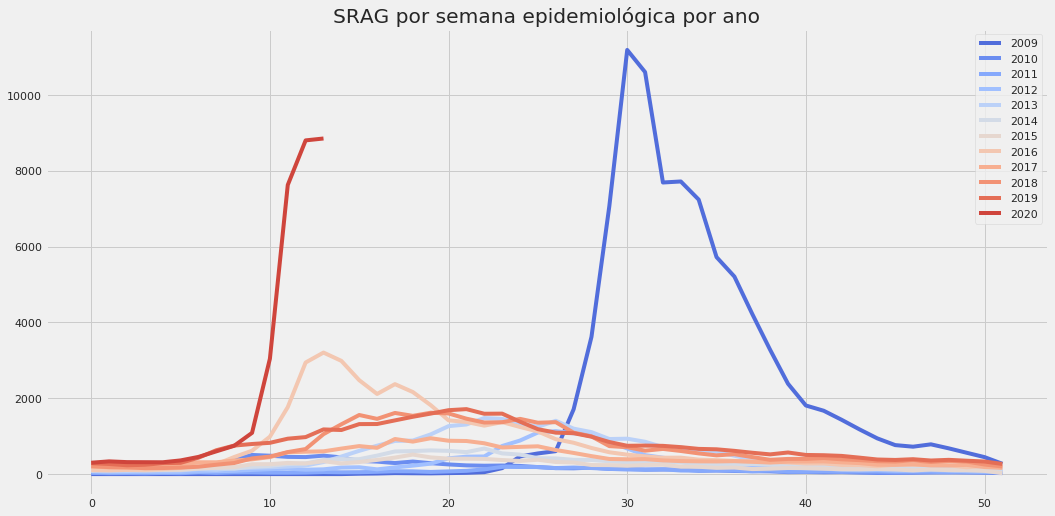

In [159]:
palette = sns.color_palette("coolwarm", len(df_srag.columns))
ax = sns.lineplot(data=df_srag, palette=palette, dashes=False)
ax.set_title('SRAG por semana epidemiológica por ano')

Uma visão alternativa para esses mesmos dados, que enfatiza a proporção em cada ano.

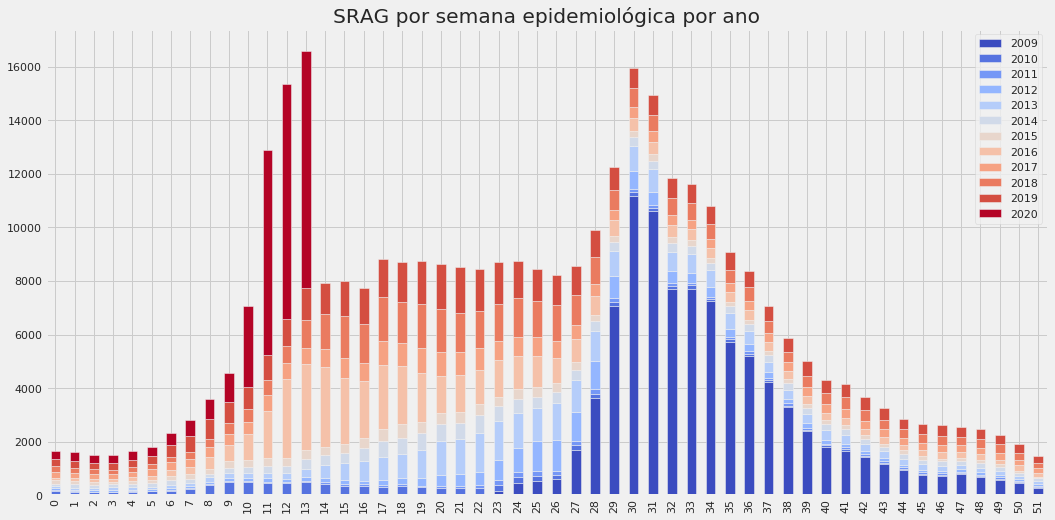

In [158]:
df_srag.plot(kind='bar', stacked=True, colormap='coolwarm', title='SRAG por semana epidemiológica por ano')

Vemos que em 2009 houve um pico bastante anormal, certamente por conta da epidemia de H1N1.

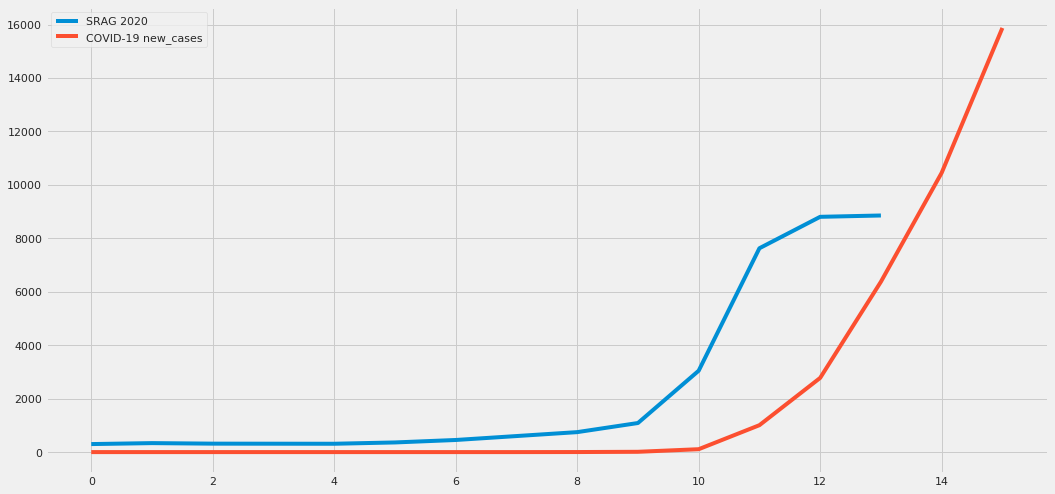

In [85]:
df_comparison =pd.concat([df_srag[2020].rename('SRAG 2020'), 
                          df_covid_target['new_cases'].rename('COVID-19 new_cases').reset_index(drop=True)], axis=1)

ax = sns.lineplot(data=df_comparison, dashes=False)

Qual a magnitude da diferença ao longo do tempo?

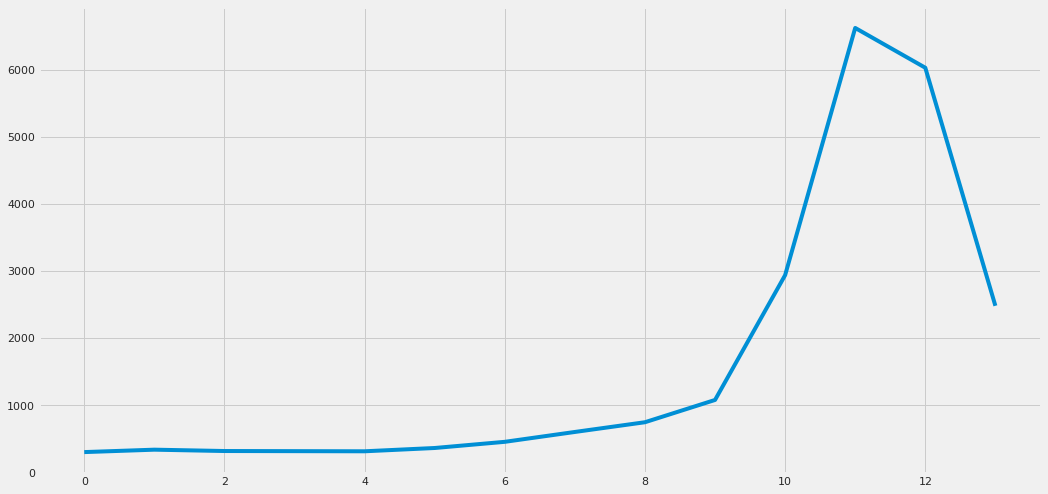

In [71]:
ax = sns.lineplot(data=(df_comparison.iloc[:, 0] - df_comparison.iloc[:, 1]), dashes=False)

## Estimativa de Efeito Causal

Para estimar o efeito causal supostamente introduzido pela COVID-19, usaremos [a biblioteca CausalImpact](https://github.com/dafiti/causalimpact), a qual exige que os dados sejam dispostos de forma linear no tempo.

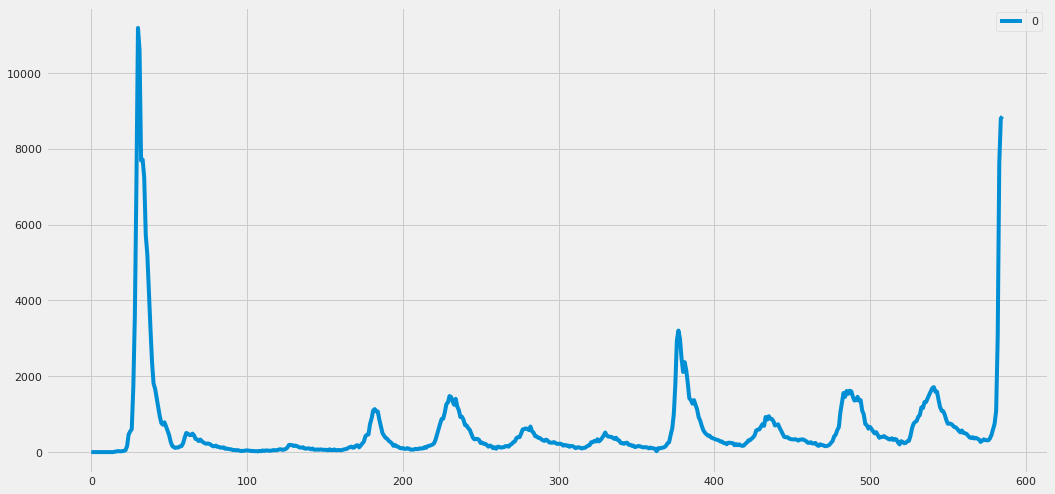

In [72]:
ax = sns.lineplot(data=df_srag_timeline, dashes=False)

Coloquemos a suposta intervenção causal na primeira semana de 2020.

In [87]:
years

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020])

Intervention week: 573
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2710.17            32522.0
Prediction (s.d.)         654.37 (282.78)    7852.47 (3393.39)
95% CI                    [73.47, 1181.96]   [881.65, 14183.51]

Absolute effect (s.d.)    2055.79 (282.78)   24669.53 (3393.39)
95% CI                    [1528.21, 2636.7]  [18338.49, 31640.35]

Relative effect (s.d.)    314.16% (43.21%)   314.16% (43.21%)
95% CI                    [233.54%, 402.93%] [233.54%, 402.93%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


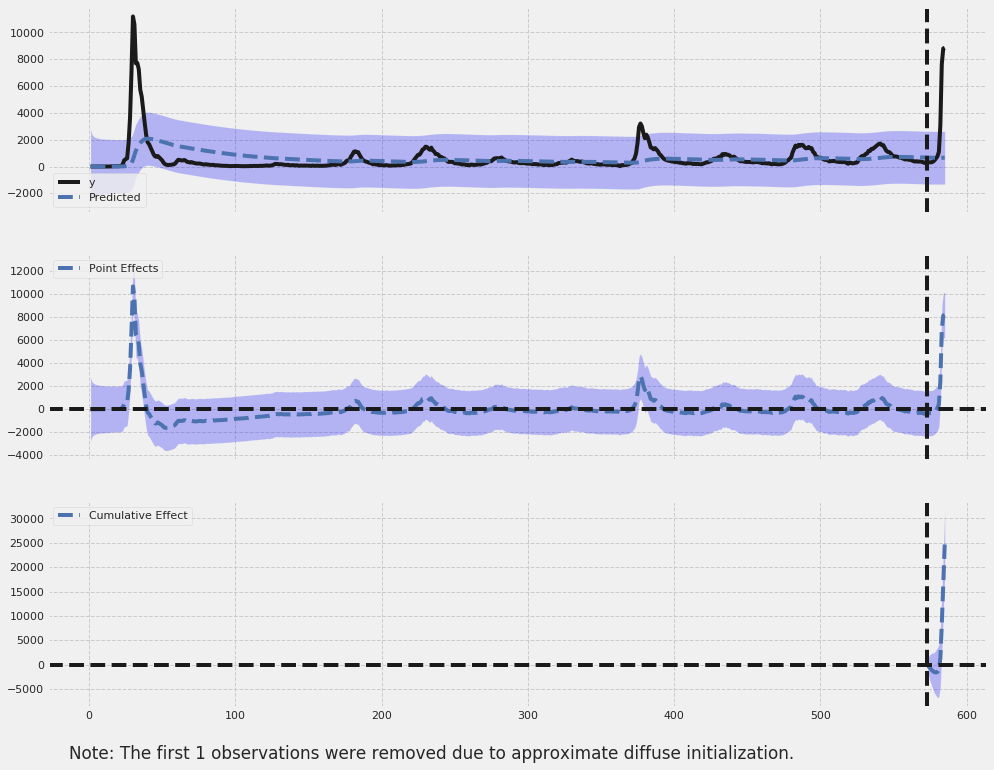

In [90]:
intervention_week = (len(years) - 1) * 52 + 1 # all years, except the lat one, plus a week
print("Intervention week:", intervention_week)
pre_period = [0, intervention_week]
post_period = [intervention_week+1, 585]

ci = CausalImpact(df_srag_timeline, pre_period, post_period)
print(ci.summary())
#print(ci.summary(output='report'))
ci.plot()

Podemos então isolar o efeito estimado.

In [91]:
df_causal_effect = ci.inferences[['post_cum_effects', 'post_cum_effects_lower', 'post_cum_effects_upper']].dropna()
df_causal_effect.head()

,post_cum_effects,post_cum_effects_lower,post_cum_effects_upper
573,0.000000,0.000000,0.000000
574,-338.372915,-2195.138235,1723.333811
575,-678.745829,-3428.771416,2172.558216
576,-1021.118744,-4241.043831,2367.444010
577,-1314.491659,-5082.551824,2417.531319


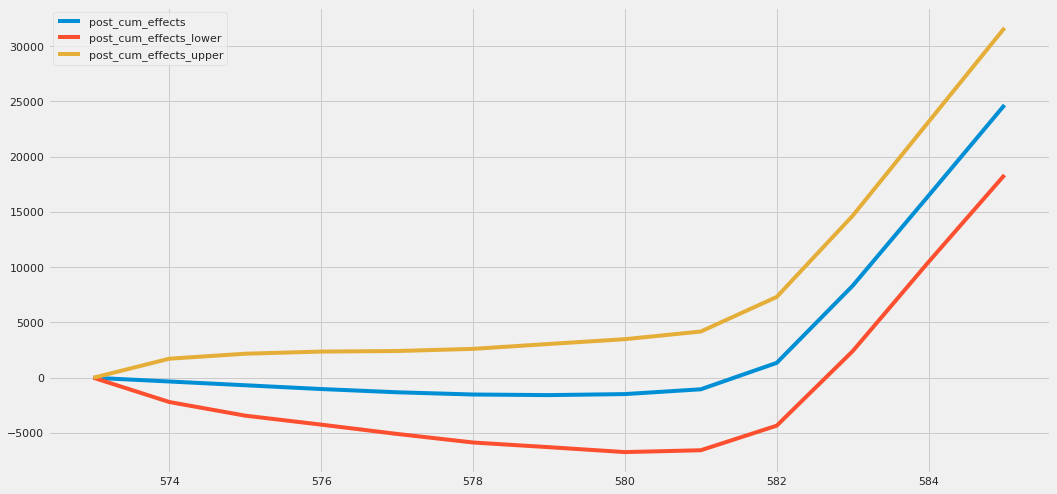

In [92]:
ax = sns.lineplot(data=df_causal_effect, dashes=False)

In [ ]:
df_comparison_2 =pd.concat([df_causal_effect['post_cum_effects'].reset_index(drop=True), 
                            df_covid_target['new_cases'].reset_index(drop=True)], axis=1)

ax = sns.lineplot(data=df_comparison_2, dashes=False)

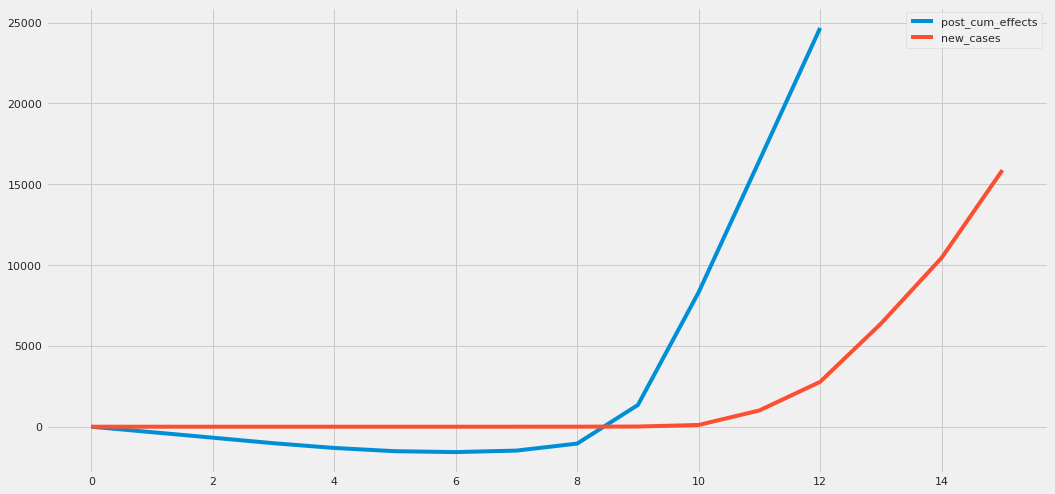

In [93]:
df_comparison_2 =pd.concat([df_causal_effect['post_cum_effects'].reset_index(drop=True), 
                            df_covid_target['new_cases'].reset_index(drop=True)], axis=1)

ax = sns.lineplot(data=df_comparison_2, dashes=False)

E calcular a razão entre SRAGs e COVID-19 oficial.

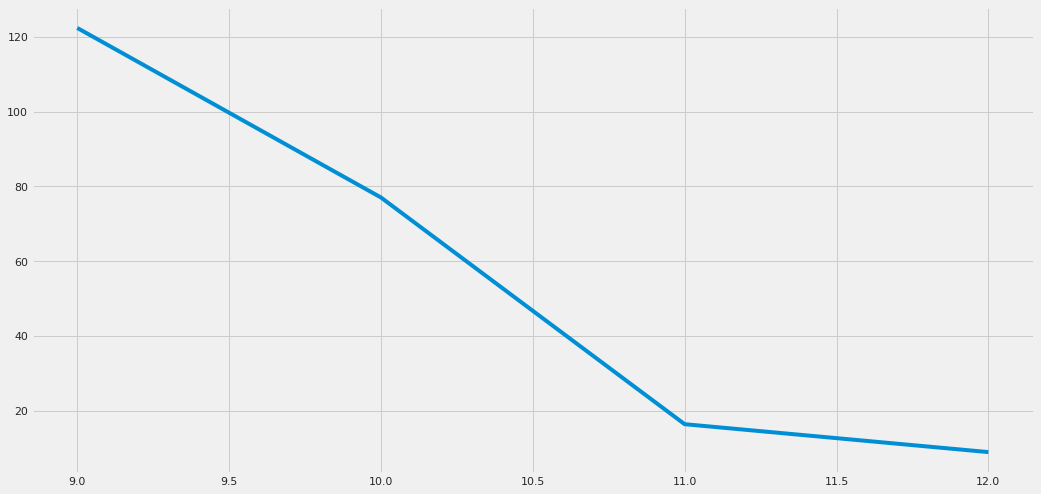

In [103]:
s_a = df_causal_effect['post_cum_effects'].reset_index(drop=True)
s_b =  df_covid_target['new_cases'].reset_index(drop=True)
s_ratio = (s_a/s_b)
ax = sns.lineplot(data=s_ratio[s_ratio > 0], 
                  dashes=False)

## Conclusão

Nota-se grande discrepância entre casos usuais de SRAG e casos reportados. Atribuimos assim os casos adicionais à COVID-19. Note-se ainda que os casos de SRAG reportados referem-se a hospitalizações, que são apenas uma parte dos casos totais esperados de COVID-19. Portanto, para se estimar os casos totais de COVID-19, devemos ainda ajustar a estimativa de hospitalizados de acordo com a probabilidade de ser hospitalizado dado que se tem COVID-19.

In [95]:
p_hospitalization = 0.2

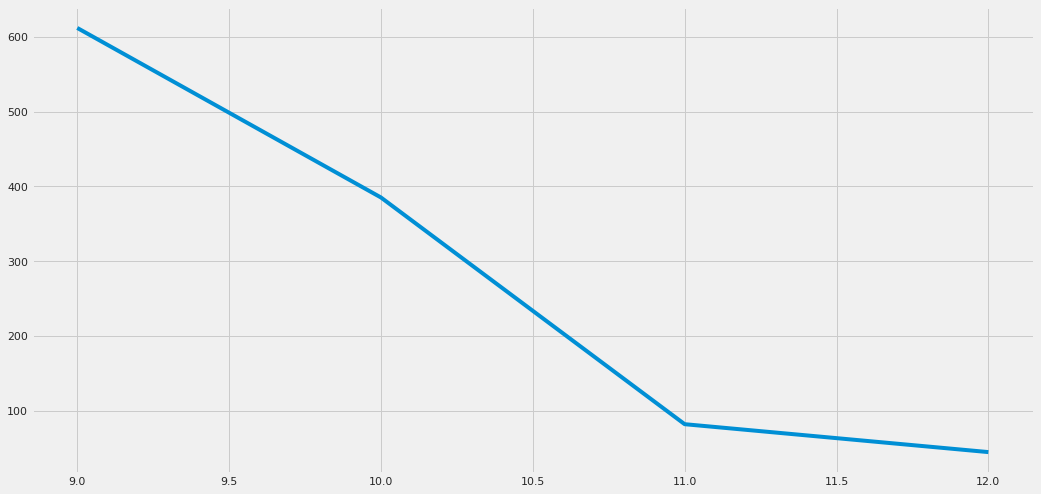

In [137]:
s_adjustment_multipler = s_ratio[s_ratio > 0] / p_hospitalization
s_adjustment_multipler = s_adjustment_multipler.rename('SRAG_adjustment_multiplier')
ax = sns.lineplot(data=s_adjustment_multipler, 
                  dashes=False)

Vemos assim que as diferenças estimadas são bastante expressivas, o que deve ter impacto na previsão da dinâmica epidemiológica.

Salvemos esses multiplicadores de ajuste para uso posterior. Por conveniência, vamos diarizar esses valores.

In [139]:
weeks = range(0, s_adjustment_multipler.index[-1])

In [142]:
df_daily_adjustment_multipler = \
    df_covid_target\
        .reset_index()\
        .merge(s_adjustment_multipler, left_index=True, right_index=True)\
        .set_index('date')\
        .resample('D')\
        .bfill()\
        [['SRAG_adjustment_multiplier']]

df_daily_adjustment_multipler

,SRAG_adjustment_multiplier
date,
2020-03-08,612.110804
2020-03-09,385.197725
2020-03-10,385.197725
2020-03-11,385.197725
2020-03-12,385.197725
2020-03-13,385.197725
2020-03-14,385.197725
2020-03-15,385.197725
2020-03-16,81.777050


In [146]:
df_daily_adjustment_multipler.to_csv('../results/srag_adjustment_multipliers.brazil.csv')